In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import scipy.io
from scipy.signal import lfilter,butter,filtfilt
import itertools
from scipy.stats import pearsonr
from scipy.signal import welch
#import seaborn as sns

In [2]:
nic=scipy.io.loadmat('CircuitROIsMTS/LMP_NIC_12_FP_mean_denoisedTS.mat')
data = nic['mts'].T
print(data.shape)

(29, 3890)


In [3]:
roinames = nic["roi_names"].flatten()
for name in roinames:
    print(name[0])

ACC
L_Acb
L_Amygdala
L_Amygdala_CM_Juelich50
L_Amygdala_LB_Juelich50_minus_intersect
L_Amygdala_SF_Juelich50
L_Caudate
L_FOrb
L_Hipp
L_Insula
L_MidFG
L_Pallidum
L_Putamen
L_SN_Hammersn30r83_74
L_Thalamus
R_Acb
R_Amygdala
R_Amygdala_CM_Juelich50
R_Amygdala_LB_Juelich50_minus_intersect
R_Amygdala_SF_Juelich50
R_Caudate
R_FOrb
R_Hipp
R_Insula
R_MidFG
R_Pallidum
R_Putamen
R_SN_Hammersn30r83_75
R_Thalamus


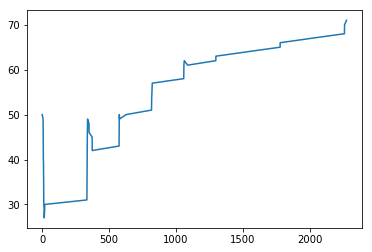

In [4]:
nict = scipy.io.loadmat('CircuitROIsMTS/LMP_NIC_12-FP/10-Apr-2017_09-57_LMP_NIC_12_FP.mat')
craving = nict['craveUpdate']
crav_t=(craving[0][0][0].T).flatten()
crav_v=(craving[0][0][1].T).flatten()
plt.plot(crav_t,crav_v)

In [5]:
# create a 10th order Butterworth filter from 0.01 to 0.1 Hz
def butter_bandpass(lowcut,highcut,fs,order=8):
    nyq = 0.5*fs
    low = lowcut/nyq
    high = highcut/nyq

    b,a = butter(order, [low, high], btype='band')
    return b,a

def butter_bandpass_filter(data,lowcut,highcut,fs,order=5):
    b,a = butter_bandpass(lowcut,highcut,fs,order=order)
    return filtfilt(b,a,data)

sampling_freq = 1/0.802
print(sampling_freq)

1.2468827930174562


[ 316  556  796 1036 1276 1516 1756 1996 2236 2476]


/Users/hstrey/anaconda/envs/python3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


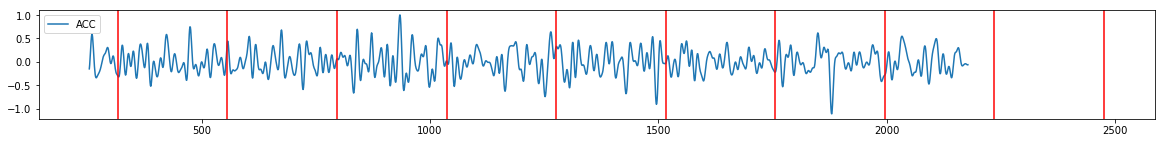

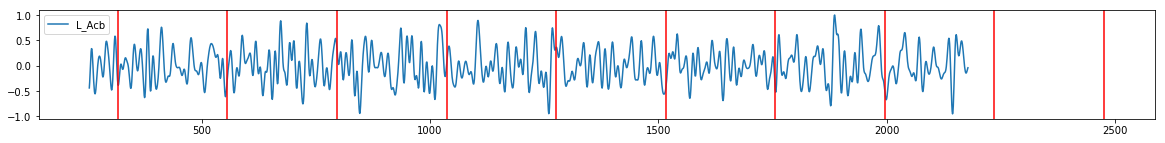

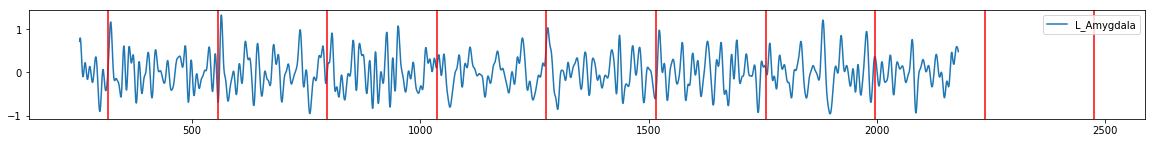

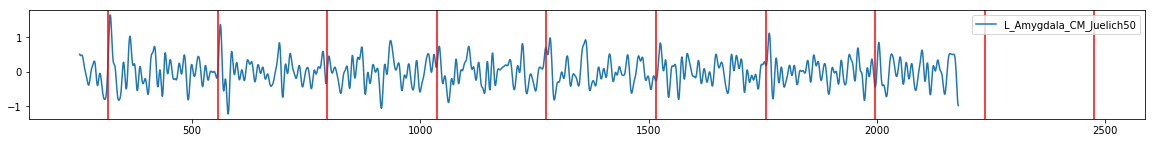

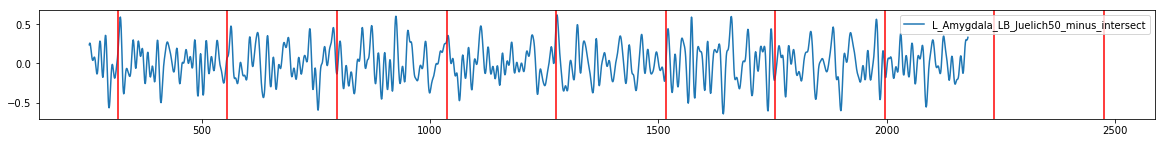

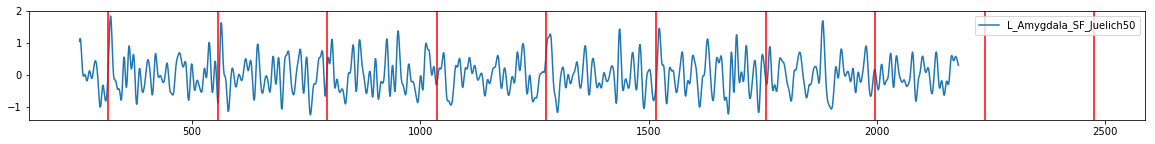

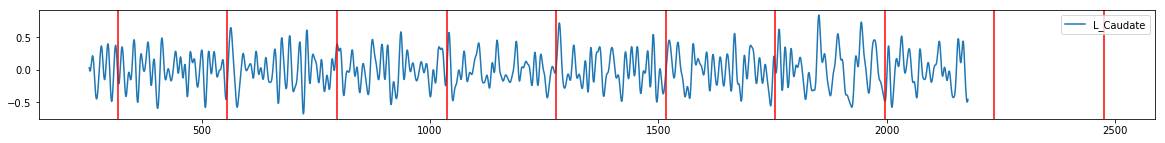

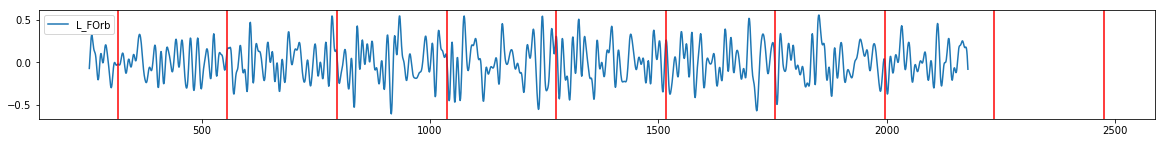

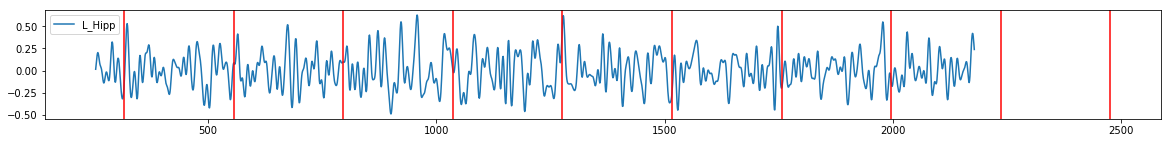

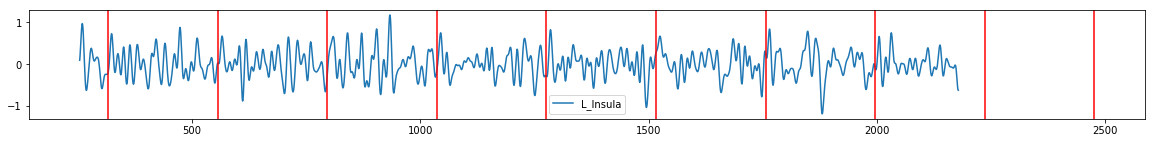

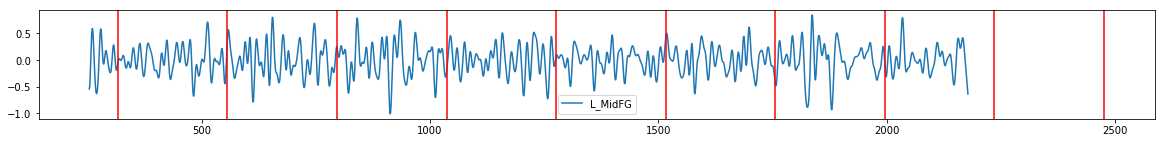

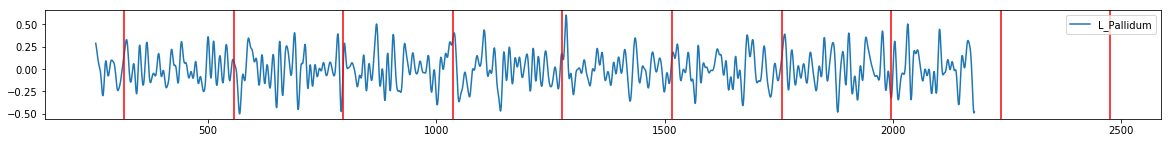

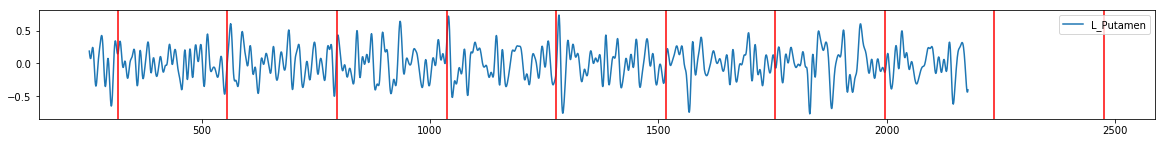

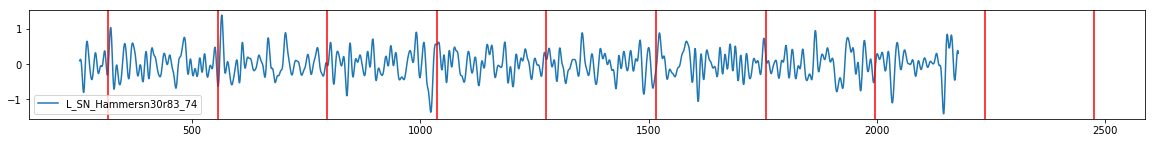

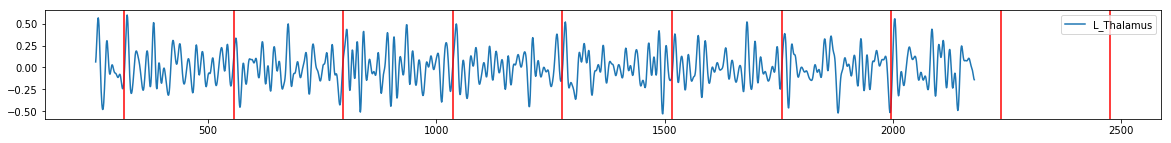

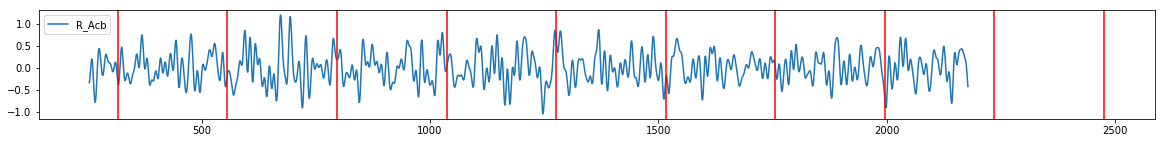

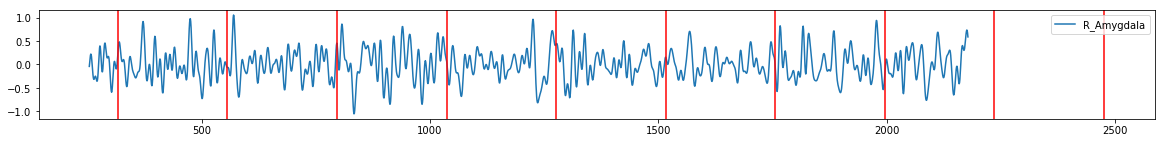

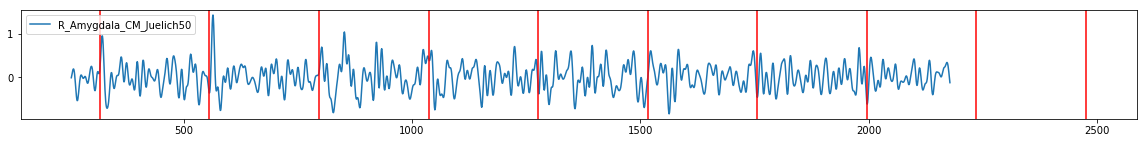

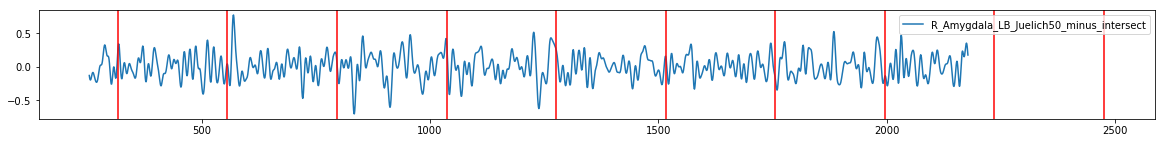

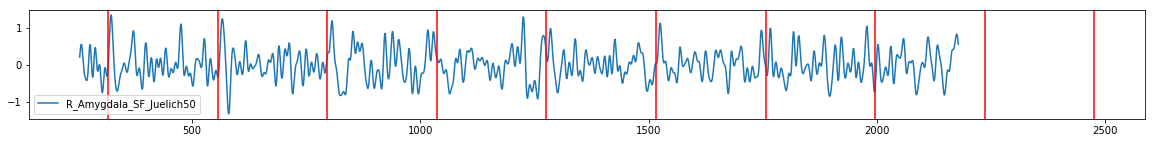

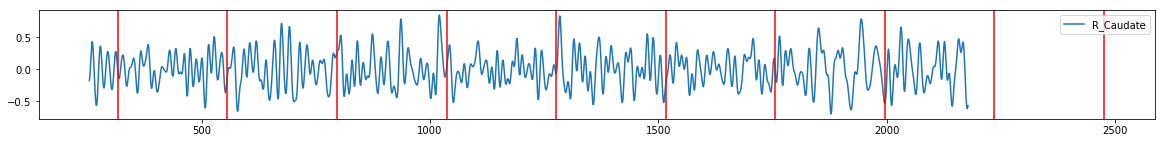

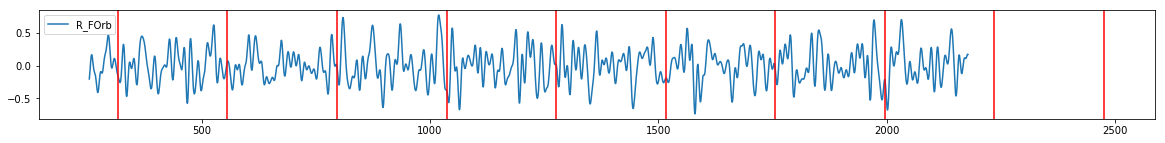

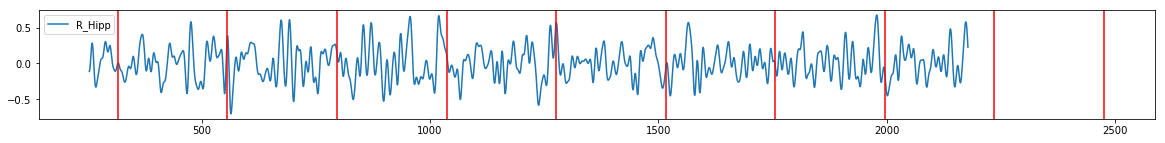

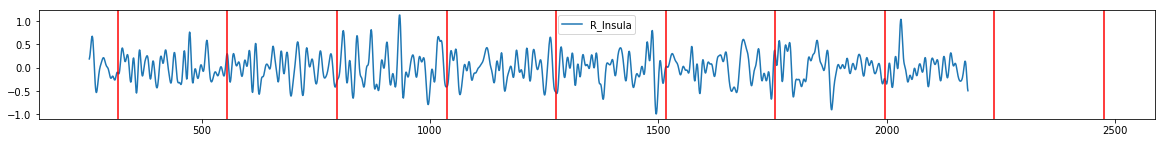

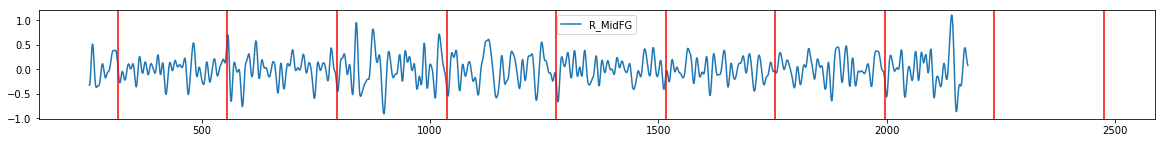

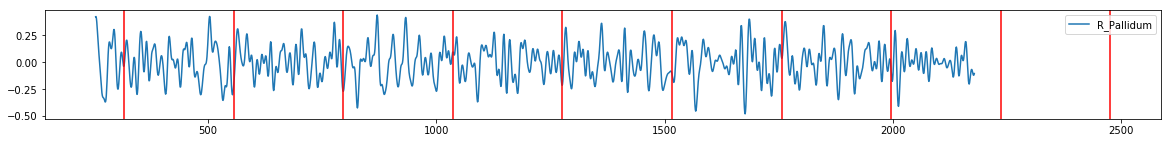

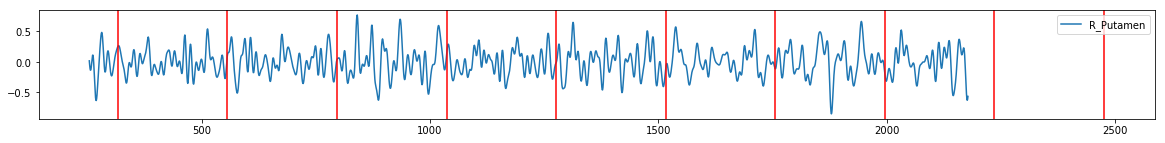

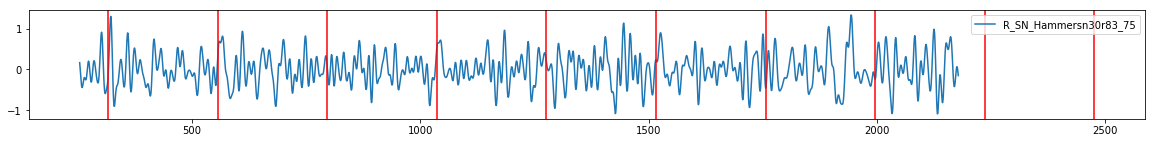

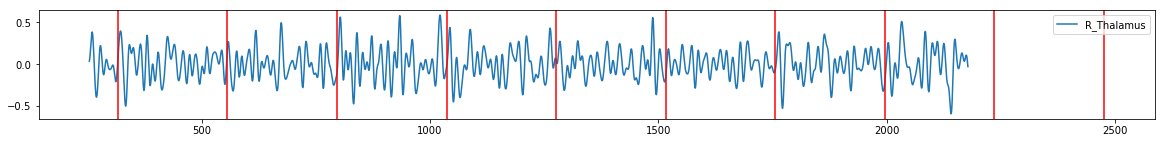

In [12]:
t = np.linspace(0,3889*.802,3890)
data_filtered = None
puffs=np.arange(316,2500,240)
print(puffs)
for trace,name in zip(data,roinames):
    trace_filtered = butter_bandpass_filter(trace,0.01,0.1,sampling_freq,order=5)
    plt.figure(figsize=(20,2))
    plt.plot(t[316:316+10*240+1],trace_filtered[316:316+10*240+1],label=name[0])
#    plt.xlim((0,1000))
    for p in puffs:
        plt.axvline(x=p,color="r")
    plt.legend()
    if data_filtered is None:
        data_filtered = trace_filtered
    else:
        data_filtered = np.vstack((data_filtered,trace_filtered))

In [ ]:
data_filtered.shape

In [ ]:
plt.plot(data_filtered[0][:500])
plt.plot(data_filtered[1][:500])

In [ ]:
plt.plot(data[0][:500])
plt.plot(data[1][:500])

In [ ]:
def pearson_combined(data):
    results = None
    for perm in itertools.combinations(range(data.shape[0]),2):
        pc=pearsonr(data[perm[0]],data[perm[1]])
        result=np.array([perm[0],perm[1],pc[0],pc[1]])
        if results is None:
            results = result
        else:
            results = np.vstack((results,result))
    return results
results_array = pearson_combined(data_filtered)

In [ ]:
sorted_results=results_array[results_array[:,2].argsort()[::-1]]

In [ ]:
for i,j,pr,pp in sorted_results:
    print(i,j,roinames[int(i)],roinames[int(j)],pr,pp)

In [ ]:
def sliding_window_pearson(data1,data2,window_size,step=1):
    pr = [pearsonr(data1[index:index+window_size],data2[index:index+window_size])[0]
          for index in range(0,min(data1.size,data2.size),step)]
    pr = np.array(pr)
    return pr

In [ ]:
plt.plot(sliding_window_pearson(data_filtered[15],data_filtered[22],100))
for p in puffs:
    plt.axvline(x=p,color="r")


In [ ]:
# new strategy:
# we compare pearson correlations of the puffs to r's from time where there is no delivery
# two time series: puffs from first puff to 2min after last puff
# nopuffs - the rest
plt.plot(range(data_filtered[15].size),data_filtered[15])
plt.plot(range(316,316+10*240+1),data_filtered[15][316:316+10*240+1]+0.5)
for p in puffs:
    plt.axvline(x=p,color="r")



In [ ]:
data_puffs = data_filtered[:,316:316+10*240+1]
data_nopuffs1=data_filtered[:,:316]
data_nopuffs2=data_filtered[:,316+10*240+1:]
data_nopuffs=np.hstack((data_nopuffs1,data_nopuffs2))
print(data_puffs.shape, data_nopuffs.shape)
print(data_puffs.shape[1]+data_nopuffs.shape[1])

In [ ]:
results_puffs = pearson_combined(data_puffs)
sorted_results_puffs=results_puffs[results_puffs[:,2].argsort()[::-1]]
for i,j,pr,pp in sorted_results_puffs:
    print(i,j,roinames[int(i)],roinames[int(j)],pr,pp)

In [ ]:
results_nopuffs = pearson_combined(data_nopuffs)
sorted_results_nopuffs=results_nopuffs[results_nopuffs[:,2].argsort()[::-1]]
for i,j,pr,pp in sorted_results_nopuffs:
    print(i,j,roinames[int(i)],roinames[int(j)],pr,pp)

In [ ]:
print(results_puffs.shape)

In [ ]:
results_diffp = results_puffs[:,2]-results_nopuffs[:,2]
results_diff = np.vstack((results_puffs.T,results_diffp)).T
print(results_diff.shape)

In [ ]:
sorted_results_diff=results_diff[results_diff[:,4].argsort()[::-1]]
for i,j,pr,pp,pd in sorted_results_diff:
    print(i,j,roinames[int(i)],roinames[int(j)],pr,pp,pd)

In [ ]:
# now we want to look at the unfiltered data and look at the powerspectrum
data_puffs_nofilter = data[:,316:316+10*240+1]

In [ ]:
powerspectra = None
for region,roiname in zip(data_puffs_nofilter,roinames):
    f,ps = welch(region,fs=1/0.802,nperseg=480)
    plt.figure()
    plt.plot(f,ps,label=roiname[0])
    plt.xlim((0,0.1))
    plt.xlabel("frequency in 1/s")
    plt.ylabel("power")
    plt.axvline(x=0.00519534,color="r")
    plt.legend()
    if powerspectra is None:
        powerspectra  = ps
    else:
        powerspectra = np.vstack((powerspectra,ps))


In [ ]:
print(f)

In [ ]:
totalpower=np.mean(powerspectra,axis=1)
totalpower.shape

In [ ]:
for puff,pufftotal,roiname in zip(powerspectra.T[2],totalpower,roinames):
    print(puff,puff/pufftotal,roiname[0])